### Multiple Model Accuracy comparison

In order to compare the accuracy of several rounds of training I have been using a plotting script for each round. 

This notebook is going and analyze the accuracy metrics   `per_position/per_position_data_0.5.csv` produced by several rounds of  `plot_multiple_variant_accuracy.py`. 


In [2]:
import os
from py3helpers.utils import list_dir
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from collections import defaultdict
def get_first_int(string):
    return int(re.search(r'\d+', string).group())

def read_in_mod_data():
    mods = "/Users/andrewbailey/CLionProjects/rrna_analysis/mod_files/misc/mod_file.csv"
    mods_df = pd.read_csv(mods)
    mods_df["reference_index"] = mods_df["pos"] - 1
    return mods_df



In [3]:
# Index(['contig', 'reference_index', 'strand', 'variants', 'accuracy',
#        'precision', 'negative_predictive_value', 'recall', 'specificity',
#        'positive_likelihood_ratio', 'negative_likelihood_ratio',
#        'diagnostic_odds_ratio', 'f1_score', 'prevalence', 'aucroc',
#        'avg_precision', 'brier_score'],
#       dtype='object')

def get_accuracy_df(dir_path):
    csvs = list_dir(dir_path, "csv")

    plot_me = defaultdict(defaultdict)
    for x in csvs:
        assert(os.path.exists(x))
        round_data = pd.read_csv(x)
        round_number = get_first_int(os.path.basename(x))
    #     print(round_number)
        for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
            mod = "_".join([str(x) for x in group])
    #         print(data.accuracy.iloc[0])
            plot_me[mod][round_number] = data.accuracy.iloc[0]
    data_frame = pd.DataFrame.from_dict(plot_me).T
    return data_frame

def preprocess_accuracy_csv(path, mod_data):
    assert(os.path.exists(path))
    accuracy_csv = pd.read_csv(path)

    accuracy_csv['delta1'] = accuracy_csv.reference_index.diff().shift(-1)
    accuracy_csv['delta2'] = accuracy_csv.reference_index.diff().shift(0)
    accuracy_csv['delta'] = accuracy_csv[["delta1", "delta2"]].min(axis=1)
    accuracy_csv["in_2prime"] = (((accuracy_csv.variants.shift().isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) & 
                                      (accuracy_csv.delta2 <= 5)) | 
                                     (accuracy_csv.variants.shift(-1).isin(["Aa", "Cb", "Gc", "Td", "Tdm"]) & 
                                      (accuracy_csv.delta1 <= 5))) & (~accuracy_csv.variants.isin(["Aa", "Cb", "Gc", "Td"])))  
    accuracy_csv["in_pseudo"] = (((accuracy_csv.variants.shift().isin(["Tl"]) & 
                                       (accuracy_csv.delta2 <= 5)) | 
                                      (accuracy_csv.variants.shift(-1).isin(["Tl", "Tdm"]) & 
                                       (accuracy_csv.delta1 <= 5))) & 
                                     (~accuracy_csv.variants.isin(["Tl"]))) 
    accuracy_csv["in_unknown"] = (accuracy_csv["in_pseudo"] | accuracy_csv["in_2prime"])
    mod_data = mod_data[["contig", "reference_index", "percent"]]
    accuracy_csv = pd.merge(accuracy_csv, mod_data, on=["contig", "reference_index"])
    return accuracy_csv

def plot_accuracy_over_time(directory, high_percent=100, low_percent=0, low_delta=0, high_delta=np.inf, key="accuracy"):
    """Plot accuracy over em round"""
    mod_data = read_in_mod_data()
    csvs = list_dir(dir_path, "csv")

    plot_me = defaultdict(defaultdict)
    for x in csvs:
        assert(os.path.exists(x))
        round_data = preprocess_accuracy_csv(x, mod_data)
        round_number = get_first_int(os.path.basename(x))
    #     print(round_number)
        for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
            mod = "_".join([str(x) for x in group])
            if (data["percent"].iloc[0] < high_percent and 
                data["percent"].iloc[0] > low_percent and
                data["delta"].iloc[0] > low_delta and
                data["delta"].iloc[0] < high_delta):
                plot_me[mod][round_number] = data[key].iloc[0]

    fig = plt.figure(figsize=[10, 15])
    panel1 = plt.axes([0.1, 0.5, .6, .4])
    panel1.set_title('{} over training runs'.format(key))
    # panel1.set_xlim(0)
    # panel1.set_ylim(0)

    panel1.set_xlabel('Training Round')
    panel1.set_ylabel(key)

    lines = []
    for label, data_dict in plot_me.items():
        sorted_items = sorted(data_dict.items())
        l, = panel1.plot([x[0] for x in sorted_items], [x[1] for x in sorted_items], label=label)
        lines.append(l)

    panel1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
          fancybox=True, shadow=True, ncol=4)
    annot = panel1.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(line, idx):
        posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
        annot.xy = (posx, posy)
        text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
        annot.set_text(text)
        # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
        annot.get_bbox_patch().set_alpha(0.4)


    def hover(event):
        vis = annot.get_visible()
        if event.inaxes == panel1:
            for line in lines:
                cont, ind = line.contains(event)
                if cont:
                    update_annot(line, ind['ind'][0])
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()

    fig.canvas.mpl_connect("motion_notify_event", hover)

    return plt, list(plot_me.keys())

<IPython.core.display.Javascript object>


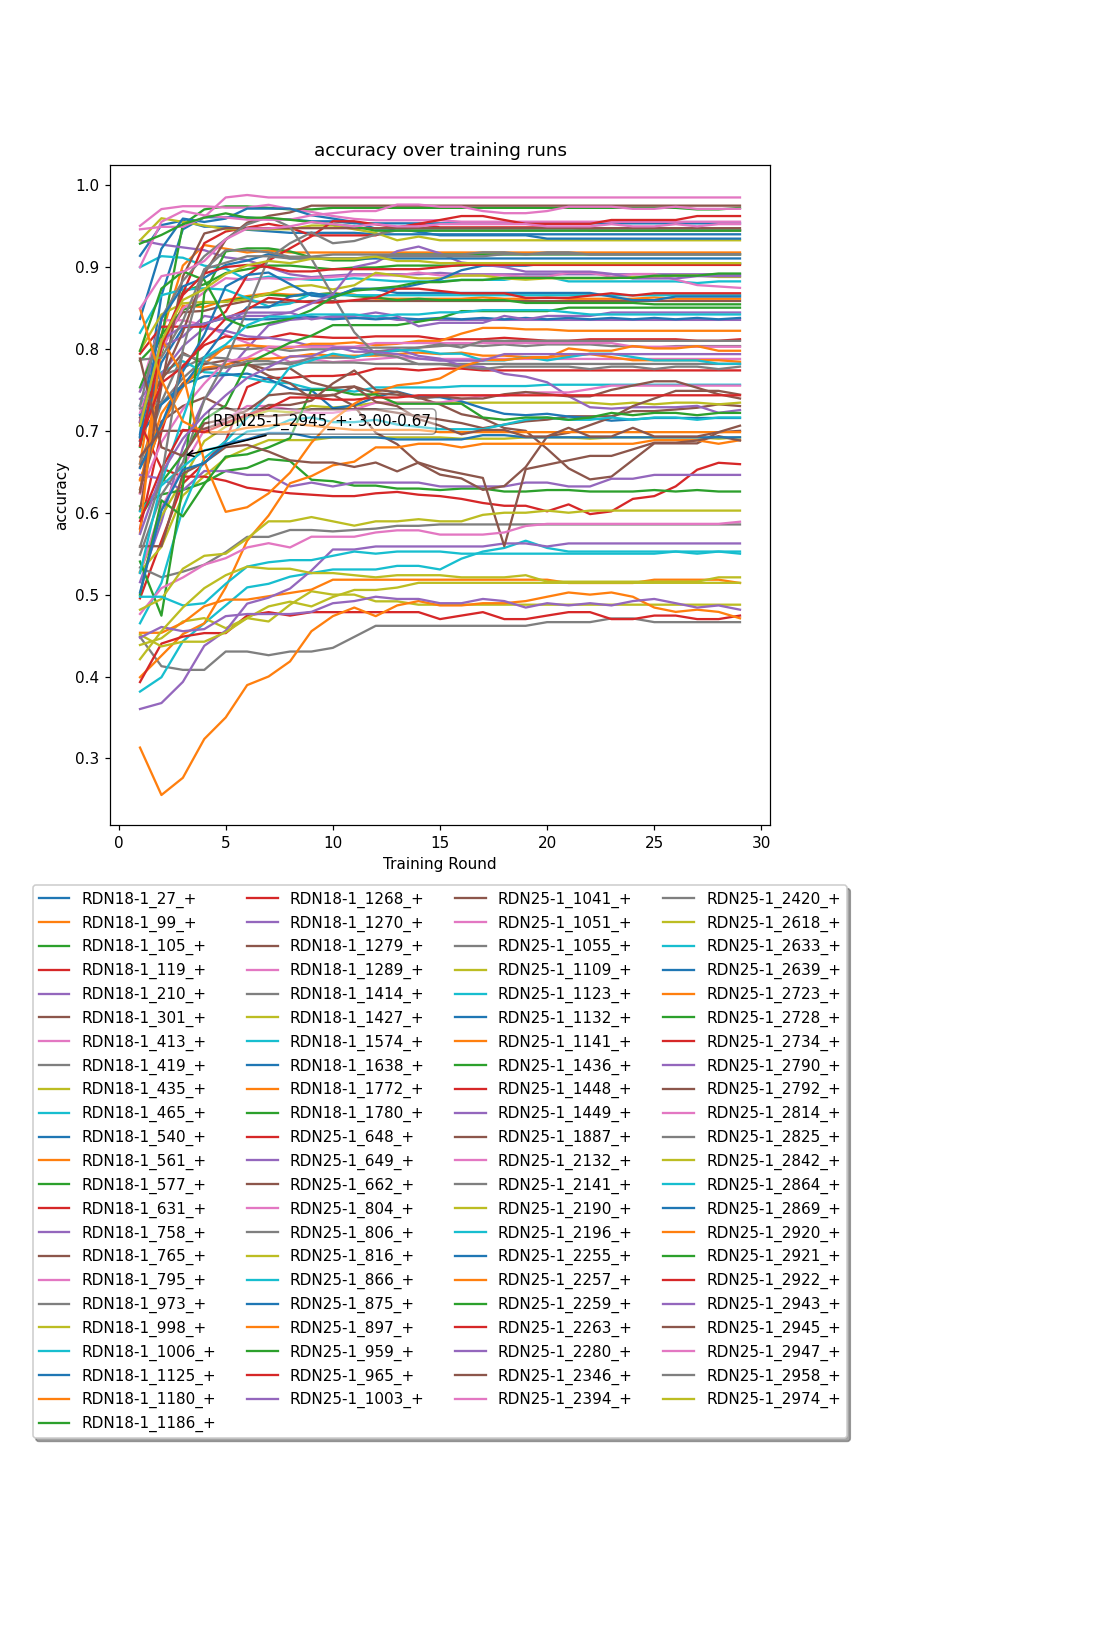

In [13]:
%matplotlib notebook
# 0.25 prob aucroc,avg_precision,brier_score
dir_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/less_data_testing_07_03_20/0.25_prob/testing_accuracy_csvs"
plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=0, low_delta=0, key="accuracy")
df = get_accuracy_df(dir_path)
subset_df = df.loc[list_o_pos]


<IPython.core.display.Javascript object>


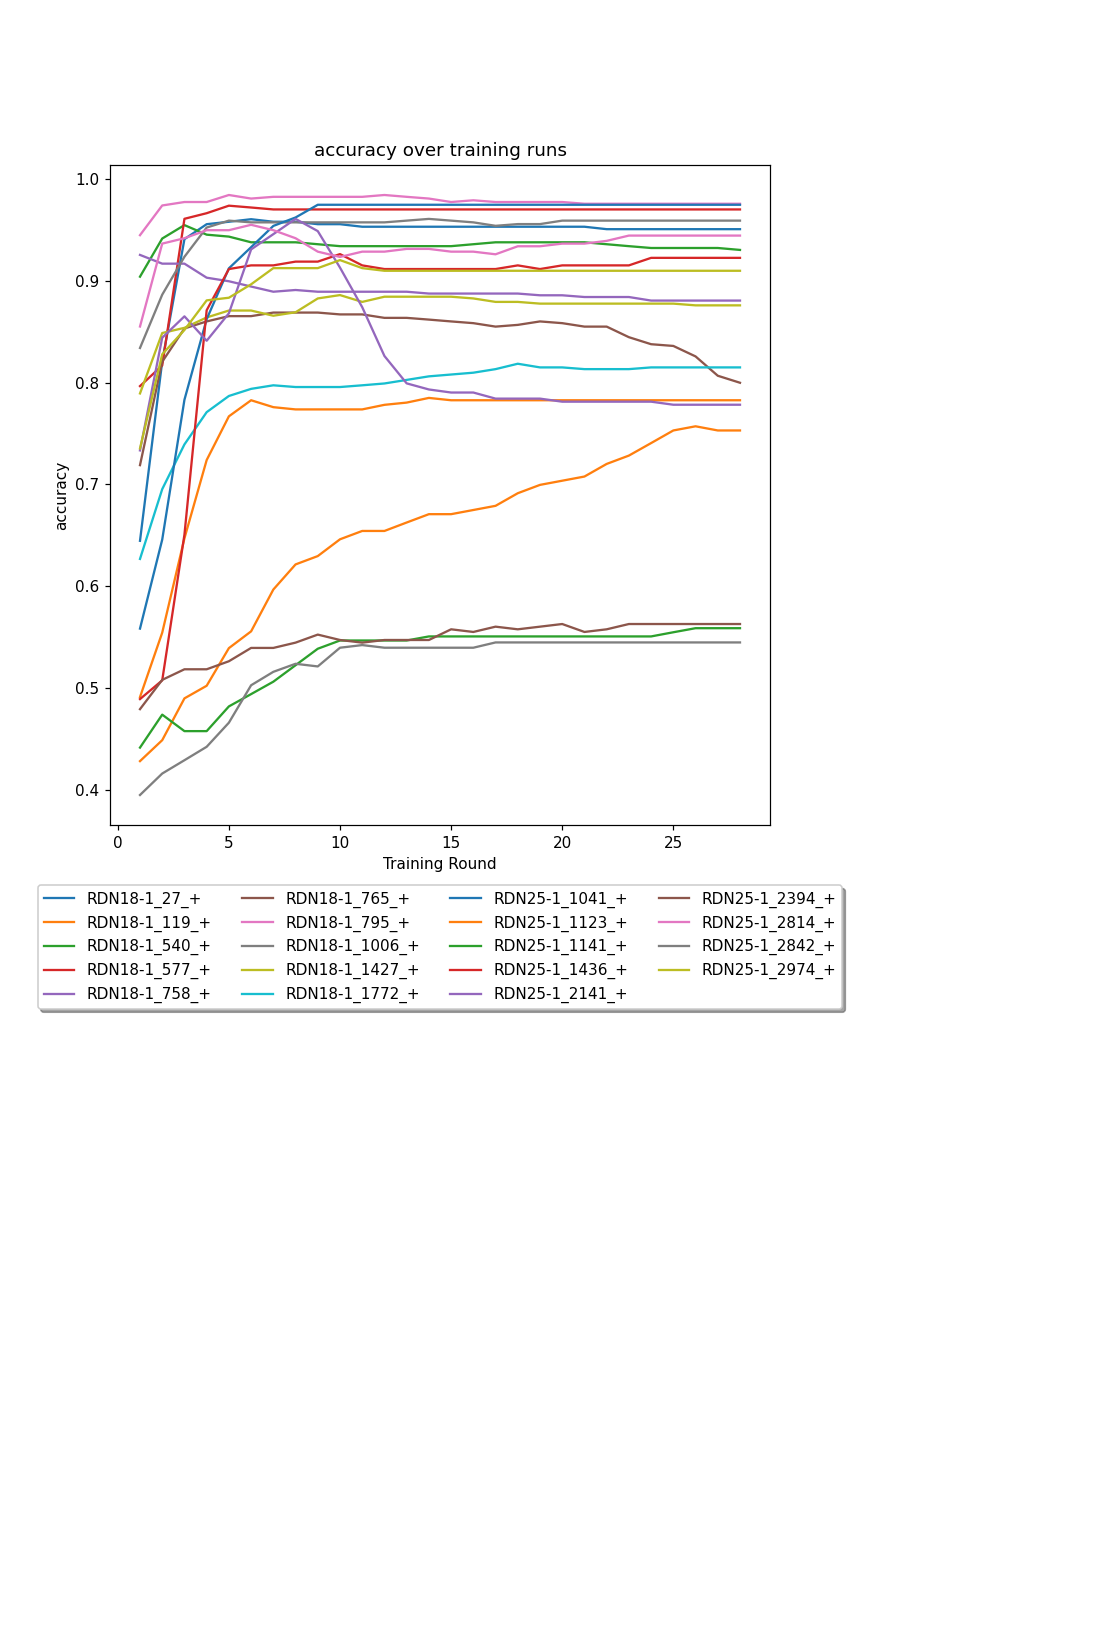

In [5]:
# 0.5 prob aucroc,avg_precision,brier_score
dir_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/less_data_testing_07_03_20/0.5_prob/testing_accuracy_csvs"
plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=94, low_delta=6, key="accuracy")
df = get_accuracy_df(dir_path)
subset_df = df.loc[list_o_pos]


<IPython.core.display.Javascript object>


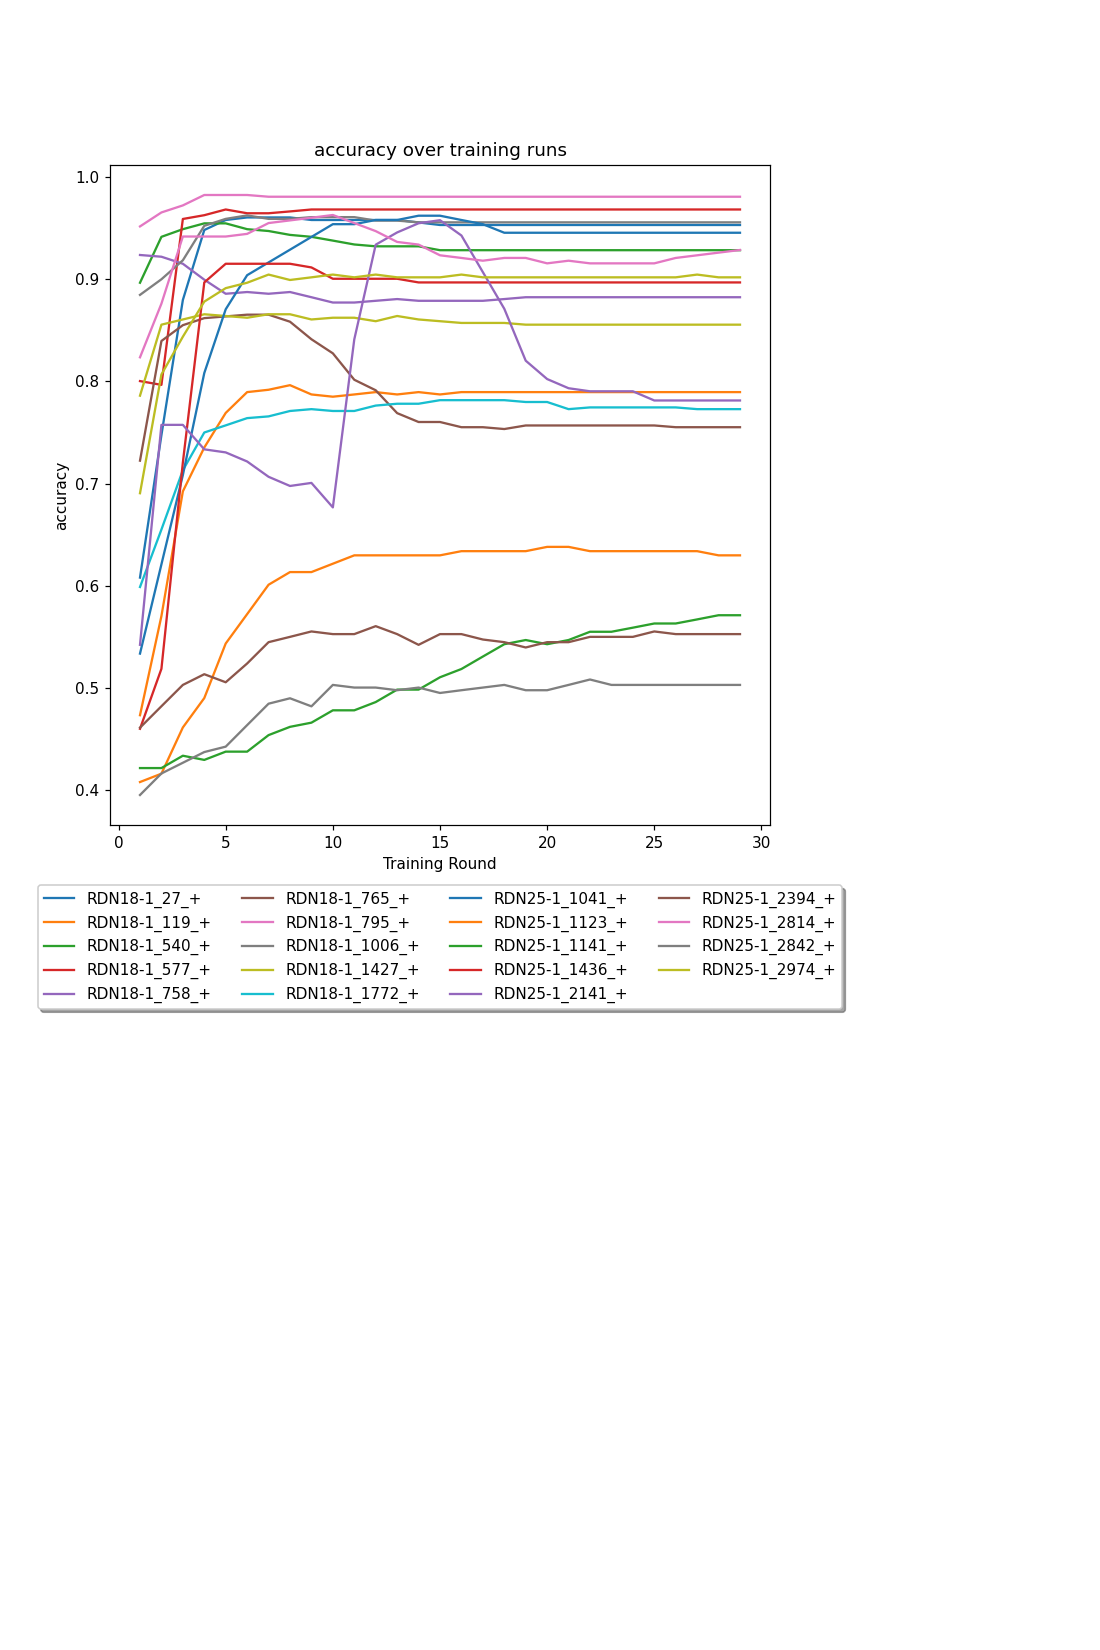

In [6]:
# 0.75  aucroc,avg_precision,brier_score
dir_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/less_data_testing_07_03_20/0.75_prob/testing_accuracy_csvs"
plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=94, low_delta=6, key="accuracy")
df = get_accuracy_df(dir_path)
subset_df = df.loc[list_o_pos]


<IPython.core.display.Javascript object>


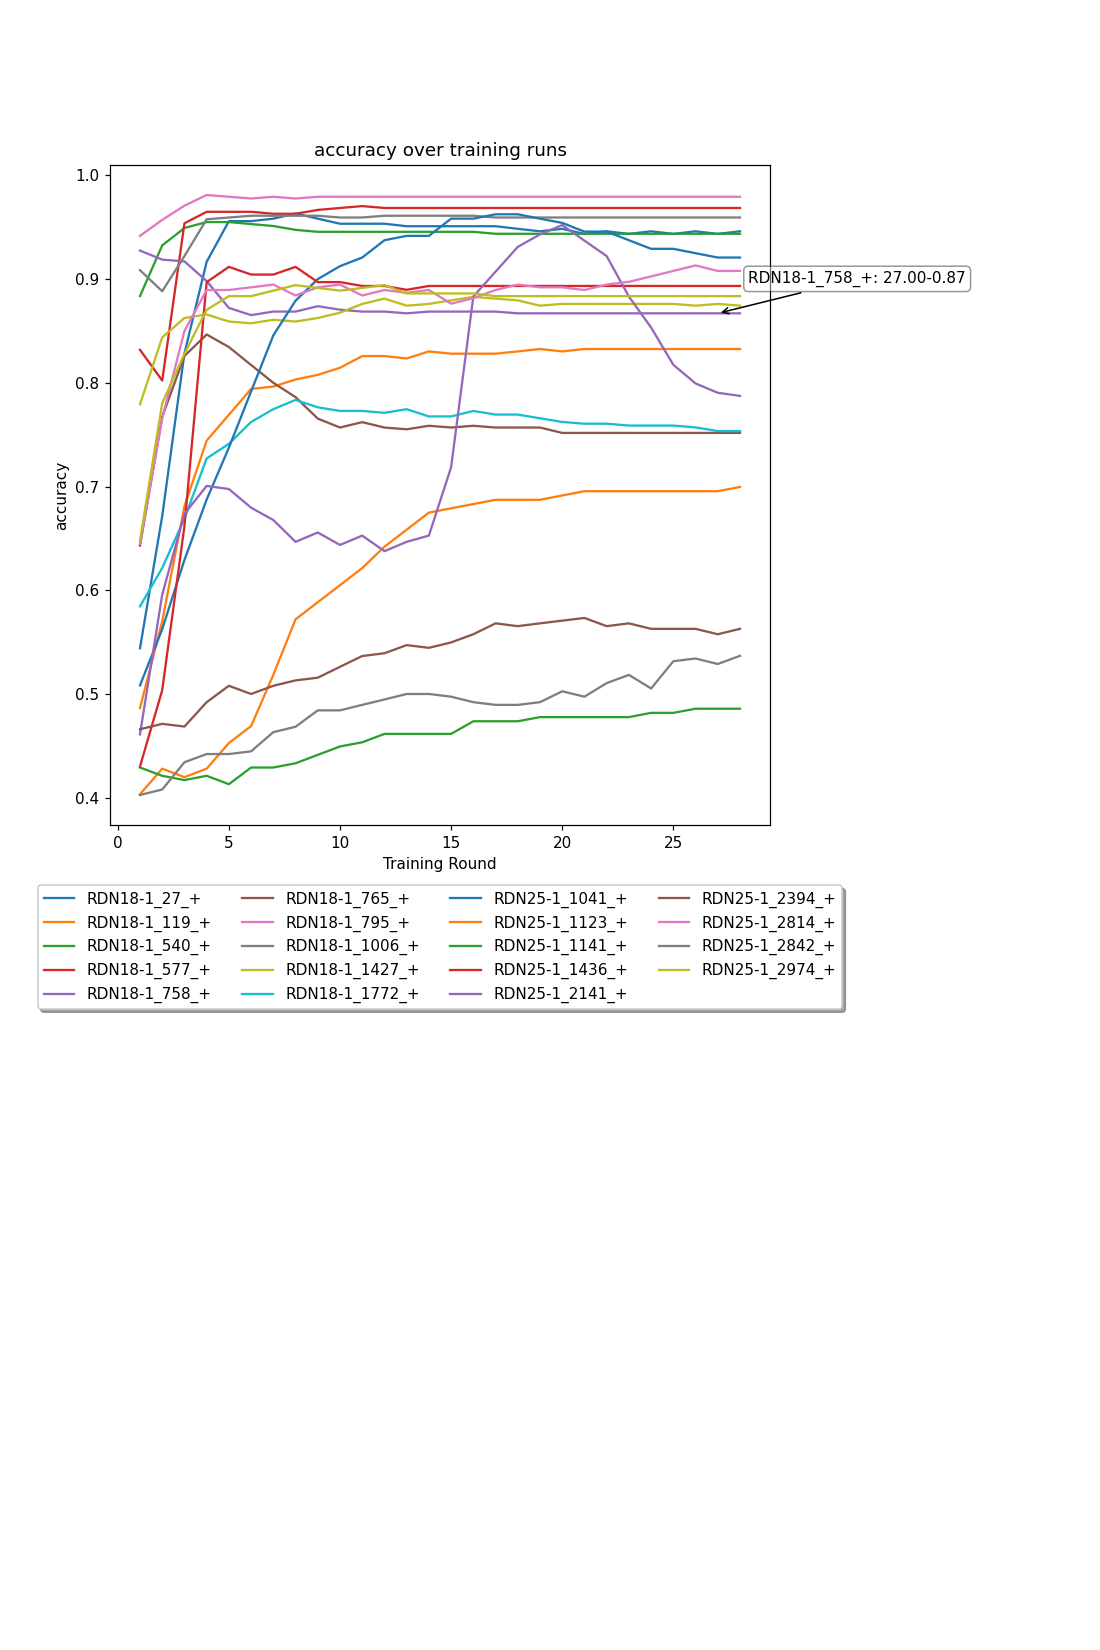

In [12]:
# 0.9 aucroc,avg_precision,brier_score
dir_path = "/Users/andrewbailey/CLionProjects/rrna_analysis/less_data_testing_07_03_20/0.9_prob/testing_accuracy_csvs"
plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=94, low_delta=6, key="accuracy")
# plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=0, low_delta=0, key="f1_score")
# plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=0, low_delta=0, key="avg_precision")
# plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=0, low_delta=0, key="brier_score")

df = get_accuracy_df(dir_path)
subset_df = df.loc[list_o_pos]


In [8]:
subset_df

,1,2,3,4,5,6,7,8,9,10,...,19,20,21,22,23,24,25,26,27,28
RDN18-1_27_+,0.5441,0.6716,0.8284,0.9167,0.9559,0.9559,0.9583,0.9632,0.9583,0.9534,...,0.9461,0.9485,0.9436,0.9461,0.9436,0.9461,0.9436,0.9461,0.9436,0.9461
RDN18-1_119_+,0.4864,0.5701,0.6810,0.7443,0.7692,0.7941,0.7964,0.8032,0.8077,0.8145,...,0.8326,0.8303,0.8326,0.8326,0.8326,0.8326,0.8326,0.8326,0.8326,0.8326
RDN18-1_210_+,0.4740,0.5281,0.6472,0.7424,0.7987,0.8247,0.8333,0.8355,0.8442,0.8506,...,0.8550,0.8550,0.8550,0.8550,0.8550,0.8550,0.8550,0.8550,0.8550,0.8550
RDN18-1_301_+,0.5498,0.6120,0.6867,0.7531,0.7573,0.7718,0.7635,0.7656,0.7635,0.7656,...,0.7718,0.7718,0.7718,0.7718,0.7718,0.7718,0.7718,0.7718,0.7718,0.7718
RDN18-1_540_+,0.8837,0.9325,0.9493,0.9550,0.9550,0.9531,0.9512,0.9475,0.9456,0.9456,...,0.9437,0.9437,0.9437,0.9437,0.9437,0.9437,0.9437,0.9437,0.9437,0.9437
RDN18-1_577_+,0.8318,0.8022,0.9538,0.9649,0.9649,0.9649,0.9630,0.9630,0.9667,0.9686,...,0.9686,0.9686,0.9686,0.9686,0.9686,0.9686,0.9686,0.9686,0.9686,0.9686
RDN18-1_618_+,0.6697,0.7883,0.8394,0.8613,0.8668,0.8723,0.8777,0.8796,0.8814,0.8905,...,0.8960,0.8960,0.8996,0.9015,0.9015,0.8996,0.8996,0.8996,0.9015,0.8978
RDN18-1_631_+,0.8477,0.8602,0.8584,0.8728,0.8692,0.8638,0.8638,0.8638,0.8638,0.8620,...,0.8638,0.8638,0.8638,0.8638,0.8638,0.8638,0.8638,0.8638,0.8638,0.8638
RDN18-1_758_+,0.9275,0.9188,0.9171,0.8981,0.8722,0.8653,0.8687,0.8687,0.8739,0.8705,...,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670
RDN18-1_765_+,0.6431,0.7672,0.8259,0.8466,0.8345,0.8172,0.8000,0.7862,0.7655,0.7569,...,0.7569,0.7517,0.7517,0.7517,0.7517,0.7517,0.7517,0.7517,0.7517,0.7517


<IPython.core.display.Javascript object>


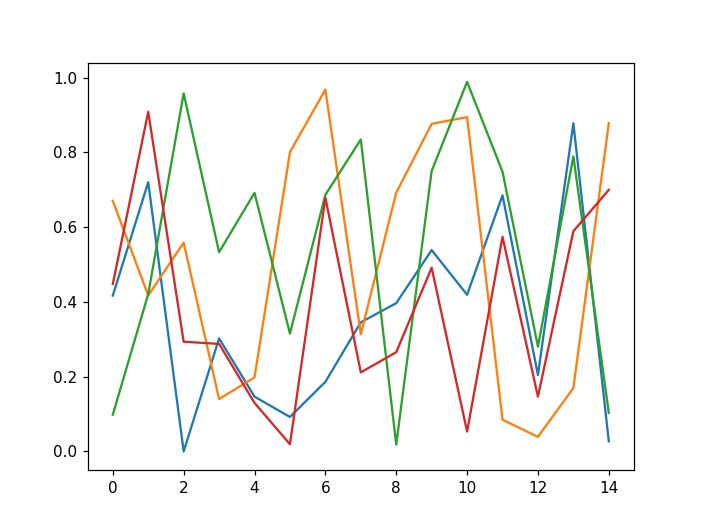

In [9]:
np.random.seed(1)
y = np.random.rand(4, 15)
x = [np.arange(15) for i in range(len(y))]
names = np.array(list("ABCD"))
fig, ax = plt.subplots()
lines = []
for i in range(len(names)):
    l, = ax.plot(x[i], y[i], label=names[i])
    lines.append(l)

annot = ax.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)


def update_annot(line, idx):
    posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
    annot.xy = (posx, posy)
    text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
    annot.set_text(text)
    # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        for line in lines:
            cont, ind = line.contains(event)
            if cont:
                update_annot(line, ind['ind'][0])
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()


fig.canvas.mpl_connect("motion_notify_event", hover)
plt.show()



6
14
27
20
28
13
1
9
16
4
25
22
3
11
19
18
2
10
23
24
17
5
8
12
21
26
7
15


<IPython.core.display.Javascript object>


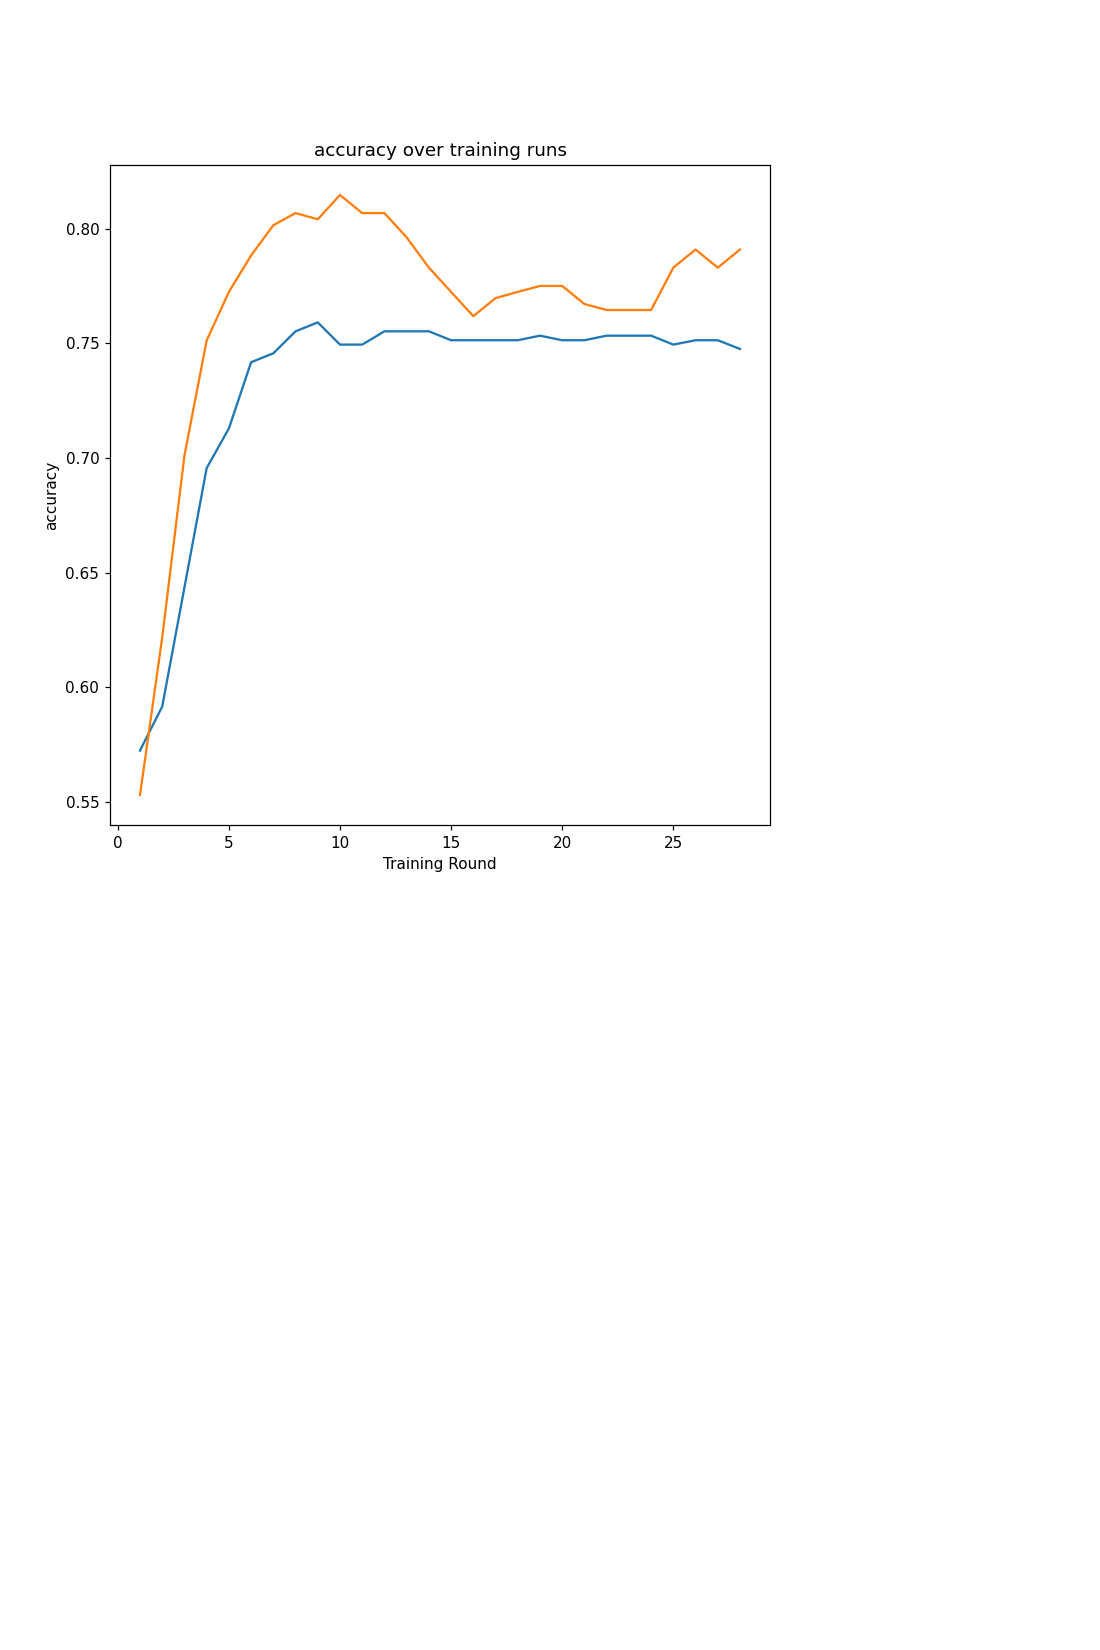

In [10]:

# def plot_accuracy_over_time(directory, high_percent=100, low_percent=0, low_delta=0, high_delta=np.inf, key="accuracy"):
directory = "/Volumes/gdrive/projects/projects/ares_rRNA/less_data_testing_07_03_20/0.9_prob/testing_accuracy_csvs"
high_percent=62
low_percent=0
low_delta=0
high_delta=np.inf
key="accuracy"
"""Plot accuracy over em round"""
mod_data = read_in_mod_data()
csvs = list_dir(dir_path, "csv")

plot_me = defaultdict(defaultdict)
for x in csvs:
    assert(os.path.exists(x))
    round_data = preprocess_accuracy_csv(x, mod_data)
    round_number = get_first_int(os.path.basename(x))
    print(round_number)
    for group, data in round_data.groupby(["contig", "reference_index", "strand"]):
        mod = "_".join([str(x) for x in group])
        if (data["percent"].iloc[0] < high_percent and 
            data["percent"].iloc[0] > low_percent and
            data["delta"].iloc[0] > low_delta and
            data["delta"].iloc[0] < high_delta):
            plot_me[mod][round_number] = data[key].iloc[0]

fig = plt.figure(figsize=[10, 15])
panel1 = plt.axes([0.1, 0.5, .6, .4])
panel1.set_title('{} over training runs'.format(key))
# panel1.set_xlim(0)
# panel1.set_ylim(0)

panel1.set_xlabel('Training Round')
panel1.set_ylabel(key)

lines = []
for label, data_dict in plot_me.items():
    sorted_items = sorted(data_dict.items())
    l, = panel1.plot([x[0] for x in sorted_items], [x[1] for x in sorted_items], label=label)
    lines.append(l)

#     panel1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08),
#           fancybox=True, shadow=True, ncol=4)
annot = panel1.annotate("", xy=(0, 0), xytext=(20, 20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

def update_annot(line, idx):
    posx, posy = [line.get_xdata()[idx], line.get_ydata()[idx]]
    annot.xy = (posx, posy)
    text = f'{line.get_label()}: {posx:.2f}-{posy:.2f}'
    annot.set_text(text)
    # annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == panel1:
        for line in lines:
            cont, ind = line.contains(event)
            if cont:
                update_annot(line, ind['ind'][0])
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)
plt.show()
# return plt, list(plot_me.keys())

# dir_path = "/Users/andrewbailey/CLionProjects/personal/projects/ares_rRNA/less_data_testing_07_03_20/0.9_prob/testing_accuracy_csvs"
# plt, list_o_pos = plot_accuracy_over_time(dir_path, high_percent=100, low_percent=94, low_delta=0, key="accuracy")
# plt.show()